In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import scipy.linalg as slin
from sklearn.linear_model import LinearRegression

In [2]:
ads = pd.read_csv("ad_table.csv")
ads['date'] = pd.to_datetime(ads.date)
ads.rename(columns={"avg_cost_per_click":"cost",'total_revenue':'revenue'},inplace=True)

In [3]:
ads.head()

,date,shown,clicked,converted,cost,revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


In [4]:
X = ads.loc[:,['ad','date','shown']]
firstday = X.date.min()
X['days'] = X.date.map(lambda dt: (dt - firstday).days)
X['weekday'] = X.date.map(lambda dt: dt.weekday_name)

X = pd.get_dummies(X,columns=['weekday'],prefix='',prefix_sep='')
del X['Sunday']

C:\Users\Vin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  after removing the cwd from sys.path.


In [9]:
X.head()

,ad,date,shown,days,Friday,Monday,Saturday,Thursday,Tuesday,Wednesday
0,ad_group_1,2015-10-01,65877,0,0,0,0,1,0,0
1,ad_group_1,2015-10-02,65100,1,1,0,0,0,0,0
2,ad_group_1,2015-10-03,70658,2,0,0,1,0,0,0
3,ad_group_1,2015-10-04,69809,3,0,0,0,0,0,0
4,ad_group_1,2015-10-05,68186,4,0,1,0,0,0,0


In [16]:
X.ad.nunique()

40

In [18]:
time_features = [u'days', u'Friday', u'Monday', u'Saturday',u'Thursday', u'Tuesday', u'Wednesday']
def fit_linear_regression(df):
    features = df.loc[:,time_features]
    target = df['shown']

    lr = LinearRegression()
    lr.fit(features,target)

    return lr

In [19]:
lrmodels = X.groupby(by='ad').apply(fit_linear_regression)

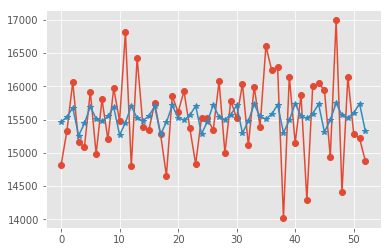

In [20]:
adname = 'ad_group_15'
data = X.loc[X.ad == adname,time_features]
ytrue = X.loc[X.ad == adname,'shown']

model = lrmodels.loc[adname]
ypred = model.predict(data)

plt.plot(data.days,ytrue,marker='o')
plt.plot(data.days,ypred,marker='*')

In [22]:
ads.head()

,date,shown,clicked,converted,cost,revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


In [23]:
def avg_net_revenue_per_show(df):
    total_net_revenue = df.revenue.sum()
    total_shown = df.shown.sum()
    return total_net_revenue / total_shown

net_revenue_per_show_grps = ads.groupby("ad").apply(avg_net_revenue_per_show).sort_values(ascending=False)


In [24]:
def __statistics(values,suffix,d):
    d['mean_{}'.format(suffix)] = values.mean()

    qs = [25, 50, 75]
    percentiles = np.percentile(values, qs)
    for q, p in zip(qs, percentiles):
        d['{}p_{}'.format(q,suffix)] = p

In [25]:
def statistics_changes(df):
    costs = df.sort_values(by='date')['cost'].values
    prev_cost = costs[:-1]
    curr_cost = costs[1:]

    d = {}
    __statistics(curr_cost / prev_cost,'chrate',d)
    __statistics(curr_cost - prev_cost,'abschg',d)

    return pd.Series(d)

C:\Users\Vin\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018A20355470>,
      dtype=object)

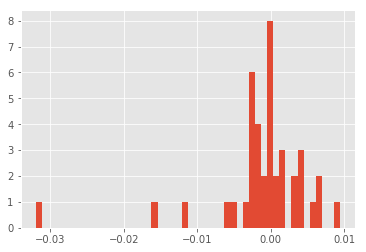

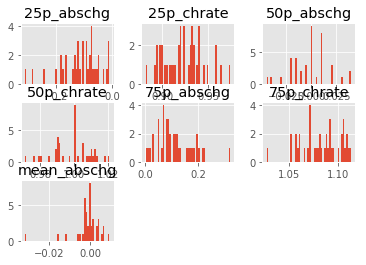

In [26]:
change_statistics = ads.groupby('ad').apply(statistics_changes)

change_statistics['mean_abschg'].hist(bins=50)

change_statistics.loc[:,[u'25p_abschg', u'25p_chrate', u'50p_abschg', u'50p_chrate',u'75p_abschg', u'75p_chrate', u'mean_abschg']].hist(bins=50)